<a href="https://colab.research.google.com/github/AlexandraLJones/FIRE-CloudComputing/blob/main/Final_Project_Polar_Home_Depot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FIRE198 Final Report - Polar Home Depot
## Improving the Classification of Polar Lows Beyond a Teachable Machine model
Katie Fernon, Riya Kanani, Chiamaka Ebulu, Ryan Birmingham



# Introduction

The goal of this deliverable is to see if we can find new methods that can be paired with pre-existing Teachable Machine models for better classification of polar lows. This team deliverable will include an exploratory analysis of different machine learning methods that we could apply to improve our classifier of polar lows. 

Then, we will apply the features we find to be the most effective in improving the classification of polar lows by implementing a decision tree system to filter the data produced by the Teachable Machine model. 



##Motivation


The motivation behind our goal was to help the communities affected by polar lows and to better identify polar lows from satellite images to recognize them in advance. Polar lows are quickly formed storms that are capable of reaching hurricane type forces. The ability to identify these storms and notify communities who may be affected could help better prepare people to face these types of storms. 

We are also motivated to improve the automation of classifying satellite imagery data as polar low storm or non-polar low images. 

# Dependencies

In order to explore the classification of images by a Teachable Machine model and to improve upon its results using analysis and filtering, we will need to use the following libraries. 

In [ ]:
# import statements
import pandas as pd  # Pandas; for reading .csv files from drive
import numpy as np  # Numpy; for efficient calculations
import matplotlib.pyplot as plt  # Matplotlib will allow us to make visuals of our data and display images
from google.colab import drive  # We import drive so that we can mount our FIRE-CC drive to the Colab environment
drive.mount('/content/gdrive') # this command is how we tell google we have permission to access the data on drive
from keras.models import load_model # used to lead in keras models
import os # Used for manipulating dictionaries 
from PIL import Image, ImageOps # Used for image processing operations
import pickle # Used to download pkl dataframe file from drive
from keras.preprocessing import image # Used for data augmentation when using deep learning, providing methods to load, prepare, and process images
from keras.applications.imagenet_utils import decode_predictions, preprocess_input # Used for training and prediction processes with models, filters images to desired criteria 
import cv2 # Used for working with images from files in the drive
from google.colab.patches import cv2_imshow # Used for graphing visuals, displaying an image in a window
from keras.models import Model # Used for importing and running teachable machine model
import tensorflow as tf # Used for model training and analysis
from sklearn.decomposition import PCA # Creates PCA imaging and analysis
from shapely.geometry import LineString # For manipulating distances between points for the purpose of visualization
from re import match # Used for searching in strings
from posixpath import defpath # Used to process file paths within our code
import seaborn as sns # Used for visuals
from sklearn.cluster import KMeans # Used for KMeans clustering
from sklearn.tree import DecisionTreeClassifier # Used for creating decision tree
from sklearn import tree # Used for creating decision tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score # Used for creating confusion matrix visuals

Mounted at /content/gdrive


# Data

### Patterns In Images

We have loaded a Polar Lows classifier that was made using Teachable Machine. We have declared this object as a `model` in the code. This object also has labels that will be used to determine what each prediction means. These labels have been loaded and and corrected in the following lines and are stored under the variable `labels`. 

In [ ]:
# Bring in Polar Lowe's model here
model = load_model('/content/gdrive/Shareddrives/FIRE-CC/FIRE298/2021/Polar Lowe\'s/RGB Model/keras_model.h5')
labels = [line[2:-2] for line in open('/content/gdrive/Shareddrives/FIRE-CC/FIRE298/2021/Polar Lowe\'s/RGB Model/labels.txt')]
print(labels)

['Polar Low', 'Non-Polar Low', 'Non-Satellite Image']


Let's start by using pickle to load in the provided file which contains a dataframe of the polar lows log of all the 2022 polar lows observations that our class made. We will be using a previous cohort's Teachable Machine model (Polar Lowe's team from 2021) to identify the images. This Teachable Machine model tells us if an image is a polar low or not. 

In [ ]:
# Read in of dataframe for Spring 2022
# File Path for Spring 2022 pickle file
pickle_path = '/content/gdrive/Shareddrives/FIRE-CC/pkl files/Spring2022PolarLowsClean.pkl'

with open(pickle_path,'rb') as f:
   df_2022 = pickle.load(f)
df_2022.head()

,your last name,date of Polar Low Occurance,Aqua or Terra?,"How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]",latitude of box top,longitude of box right side,latitude of box bottom,longitude of box left side,file name of PNG
0,Starr,08/11/2020,Terra,2,-57.94,-144.555,-66.748,-153.348,200811_HS1.png
1,Starr,08/11/2020,Terra,2,-58.15,-130.43,-66.98,-139.22,200811_HS2.png
2,Starr,08/10/2020,Terra,2,-51.66,-143.26,-60.43,-152.06,200810_HS1.png
3,Starr,08/13/2020,Terra,2,-53.31,-58.41,-62.11,-67.23,200813_HS1.png
4,Starr,08/14/2020,Terra,2,-59.4,-79.76,-68.26,-88.58,200814_HS1.png


Inside the above dataframe are all the same columns as in the polar lows log google sheet, including file names referring to the images we uploaded.  All the images are stored within one of two folders, either Snapshots or NonPolarLowSnapshots. The snapshot folder represents images that have the true label of 'Polar low' and the Non polar low snapshot folder has images that have the true label of 'Non polar low'.


In [ ]:
# LPRM Charles and Ryan
# this function downloads the images as an array for google collab to understand
def load_image(path): # path: where the image is stored
    img = Image.open(path)
    newsize = (224, 224)
    img = img.resize(newsize)
    x = np.array(img)[:,:,:3]
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

The below block loops the images in our data frame through the Teachable Machine model and creates a list of the true labels associated with the images. If the prediction is a 2, we elected to decline that classification because it is associated with a prediction of a non-satellite image. Since we know all of our images are satellite images, we declined this prediction classification. We ran the prediction model with the second best guess if this was the case and used that prediction as the official one for the image. 

In [ ]:
# Katie
# Create lists from the classifications and images columns in the dataframe
classifications_indices = df_2022['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]'].tolist()
images = df_2022['file name of PNG'].tolist()

# Loop all images through the model

predictions_indices = []

for i, file in enumerate(images):
  classification = classifications_indices[i]
  # this means that the image is a polar low
  if classification == '0':
    pathway = '/content/gdrive/Shareddrives/FIRE-CC/Polar Lows/NonPolarLowSnapshots/' + str(file)
    img, image_array = load_image(pathway)
  #this means that the image is a non-polar low
  else:
    pathway = '/content/gdrive/Shareddrives/FIRE-CC/Polar Lows/Snapshots/' + str(file)
    img, image_array = load_image(pathway)
  
  raw_prediction_array = model.predict(image_array)
  prediction_array = np.argmax(raw_prediction_array,axis=1)
  prediction_list = prediction_array.tolist()
  prediction = prediction_list[0]

# Bypassing error with model, choosing second highest prediction if highest is 'Non-Satellite'
# without bypassing, the labels of the model accidentally misclassify all the images
# as non-satellite images. 
  if prediction == 2:
    new_raw_prediction_array = np.delete(raw_prediction_array, prediction, axis=1)
    new_prediction_array = np.argmax(new_raw_prediction_array, axis=1)
    new_prediction_list = new_prediction_array.tolist()
    prediction = new_prediction_list[0]

  predictions_indices.append(str(prediction))

predictions = []
classifications = []

# Creates lists with strings representing the true labels and the predictions
for prediction in predictions_indices:
  if prediction == '0':
    predictions.append(labels[0])
  else:
    predictions.append(labels[1])
for classification in classifications_indices:
  if classification == '0':
    classifications.append('Non-Polar Low')
  else:
    classifications.append('Polar Low')

print('Predictions: ')
print(predictions_indices)
print(predictions)
print('True Labels / Classifications: ')
print(classifications_indices)
print(classifications)

Predictions: 
['1', '0', '0', '1', '0', '1', '1', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '1', '0', '1', '1', '1', '1', '1', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0', '0', '1', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '1', '1', '0', '1', '1', '0', '0', '1']
['Non-Polar Low', 'Polar Low', 'Polar Low', 'Non-Polar Low',

In [ ]:
# Katie
# Track the ones that are misclassified
misclassified = []
# Track the ones that are classified correctly 
correctly_classified = []

# Images contributed by (2022) cohorts
for i, prediction in enumerate(predictions):
  true = classifications[i]
  if prediction == true:
    correctly_classified.append(i)
  else:
    misclassified.append(i) 

print('Indices of images in the images list that were misclassified by model.')
print(misclassified)
print('Number of misclassified images: ' + str(len(misclassified)))
print('Indices of images in the images list that were correctly classified by model.')
print(correctly_classified)
print('Number of correctly classified images: ' + str(len(correctly_classified)))

Indices of images in the images list that were misclassified by model.
[0, 3, 8, 10, 15, 16, 17, 25, 27, 28, 30, 31, 37, 39, 46, 51, 53, 58, 60, 61, 63, 64, 69, 70, 72, 73, 77, 78, 79, 82, 83, 85, 86, 91, 92, 99, 100, 101, 102, 106, 108, 110, 111, 113, 114, 118, 121, 122, 123, 128, 129, 130, 131, 133, 135, 137, 138, 141, 152, 158, 160, 164, 165, 168, 175, 177, 178, 182, 183]
Number of misclassified images: 69
Indices of images in the images list that were correctly classified by model.
[1, 2, 4, 5, 6, 7, 9, 11, 12, 13, 14, 18, 19, 20, 21, 22, 23, 24, 26, 29, 32, 33, 34, 35, 36, 38, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 52, 54, 55, 56, 57, 59, 62, 65, 66, 67, 68, 71, 74, 75, 76, 80, 81, 84, 87, 88, 89, 90, 93, 94, 95, 96, 97, 98, 103, 104, 105, 107, 109, 112, 115, 116, 117, 119, 120, 124, 125, 126, 127, 132, 134, 136, 139, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 159, 161, 162, 163, 166, 167, 169, 170, 171, 172, 173, 174, 176, 179, 180, 181, 184]

There are four circumstances that result from the model. Each polar low and non polar low image is either correctly classified or misclassified. We create four individual lists for each classification using if-statements that filter through whether the model predicted the image correctly or not. The lists contain the image file paths of each image. 

In [ ]:
# Katie
# Creates lists of the four possible circumstances: 

# Actually PL, misclassified as NPL
incorrect_classify_pl = []
# Actually PL, classified as PL
correct_classify_pl = []
# Actually NPL, misclassified as PL
incorrect_classify_npl = []
# Actually NPL, classified as NPL
correct_classify_npl = []


pathways = []
for i, file in enumerate(images):
  classification = classifications_indices[i]

  if classification == '0':
    pathway = '/content/gdrive/Shareddrives/FIRE-CC/Polar Lows/NonPolarLowSnapshots/' + str(file)
  else:
    pathway = '/content/gdrive/Shareddrives/FIRE-CC/Polar Lows/Snapshots/' + str(file)
  pathways.append(pathway)

# Sorts image files into four possible circumstances
for i, file in enumerate(pathways):
  if classifications[i] == 'Non-Polar Low':
    if (i in misclassified):
      incorrect_classify_npl.append(file)
    else:
      correct_classify_npl.append(file)
  else:
    if (i in misclassified):
      incorrect_classify_pl.append(file)
    else:
      correct_classify_pl.append(file)


In [ ]:
# Katie
print('Results produced by the Teachable Machine model:')
print('Number of correctly classified polar lows: ' + str(len(correct_classify_pl)))
print('Number of incorrectly classified polar lows: ' + str(len(incorrect_classify_pl)))
print('Number of correctly classified non-polar lows: ' + str(len(correct_classify_npl)))
print('Number of incorrectly classified non-polar lows: ' + str(len(incorrect_classify_npl)))

Results produced by the Teachable Machine model:
Number of correctly classified polar lows: 61
Number of incorrectly classified polar lows: 30
Number of correctly classified non-polar lows: 55
Number of incorrectly classified non-polar lows: 39


Now that these are sorted, we can display the misclassified images according to their category. The two categories we are interested in plotting are below:


*   Classified as polar low but actually a non polar low
*   Classified as non polar low but actually a polar low

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


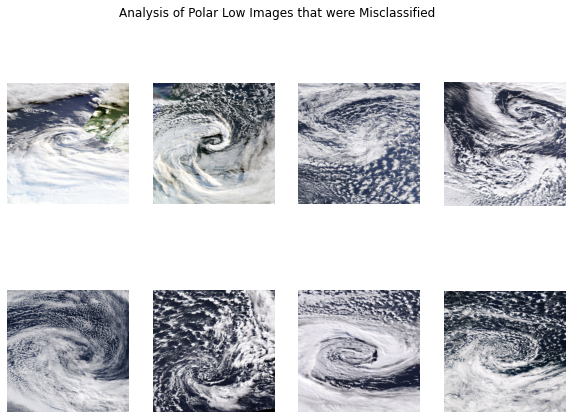

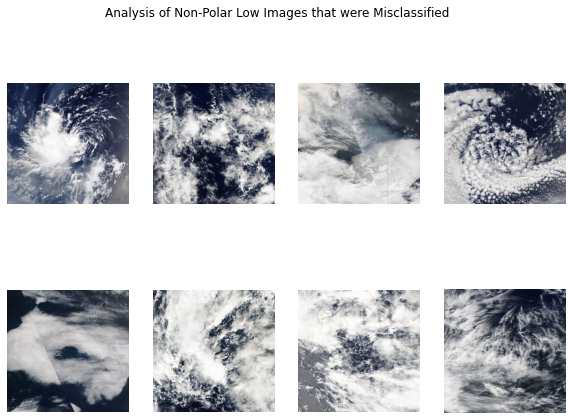

In [ ]:
# Team 2 from Polar Lows Deliverable Project
## Create a figure
fig = plt.figure(figsize=(10, 7))
  
## Setting values to rows and column variables
rows = 2
columns = 4
  
## Reading in images for incorrectly classified polar lows
image_array = []
for image in incorrect_classify_pl[0:8]: ## We want 8 images to be displayed
  image_array.append(Image.open(image))
  
## Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
fig.suptitle("Analysis of Polar Low Images that were Misclassified") ## Adds a larger, centered title on the plot
for i, image in enumerate(image_array): ## Loops through 8 images 
  fig.add_subplot(rows, columns, i+1) ## Arranges the images into rows and columns 
  plt.imshow(image)
  plt.axis('off')

fig.show()

## Same code as before but for incorrectly classified non polar low images
image_array = []
for image in incorrect_classify_npl[0:8]:
  image_array.append(Image.open(image))

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
  
fig.suptitle("Analysis of Non-Polar Low Images that were Misclassified")
for i, image in enumerate(image_array):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(image)
  plt.axis('off')

fig.show()

This chart shows us that our algorithm classifies images as polar lows when they are not if they follow the similar features to actual polar low images. 

Now let's compare these to a random assortment of correctly classified images 


*   Classified correctly as polar low
*   Classified correctly as non polar low

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


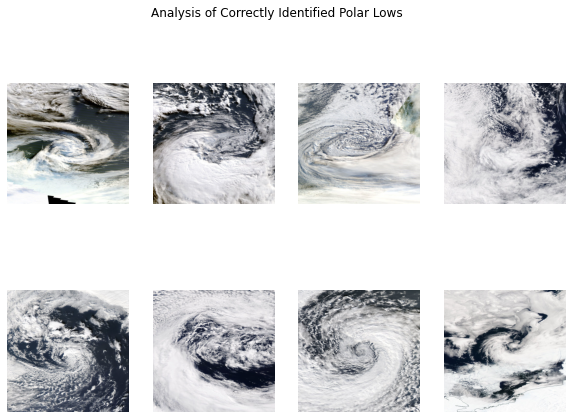

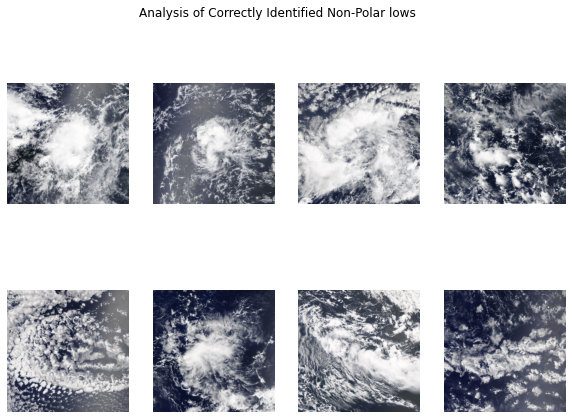

In [ ]:
# Team 2 from Polar Lows Deliverable Project
## Create a figure
fig = plt.figure(figsize=(10, 7))
  
## Setting values to rows and column variables
rows = 2
columns = 4
  
## Reading in images for correctly classified polar lows
image_array = []
for image in correct_classify_pl[0:8]: ## We want 8 images to be displayed
  image_array.append(Image.open(image))
  
## Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
fig.suptitle("Analysis of Correctly Identified Polar Lows") ## Adds a larger, centered title on the plot
for i, image in enumerate(image_array): ## Loops through 8 images 
  fig.add_subplot(rows, columns, i+1) ## Arranges the images into rows and columns 
  plt.imshow(image)
  plt.axis('off')

fig.show()

## Same code as before but for correctly classified non polar low images
image_array = []
for image in correct_classify_npl[0:8]:
  image_array.append(Image.open(image))

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
  
fig.suptitle("Analysis of Correctly Identified Non-Polar lows")
for i, image in enumerate(image_array):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(image)
  plt.axis('off')

fig.show()

These are some example images from our dataframe of polar lows and non-polar lows that are correctly classified. 

##Analysis of Scene stitching
We have decided that scene stitching is not a major factor in the classification of polar lows with the model because almost all classifications include images with scene stitching, including the correctly classified images. 

### Patterns in Metadata

The next part of this deliverable will be exploring the metadata available to us.


We are adding 1 column to the dataFrame which classifies the images as the following:
1.   Images classified as polar lows but actually are non polar lows
2.   Images classified as non-polar low but actually are polar lows
3.   Images classified correctly as polar lows
4.   Images classified correctly as non-polar lows



In [ ]:
# Team 2 Polar Lows Deliverable Project (Ryan, Riya)
## Decided to approach this by making a new column in the df_2022 dataframe that will store the prediction value for each image. Once each row has a label, we can subset the dataframe
df_2022['classifier'] = '' ## Make a new column to add to the df_2022 dataframe that will store the classifier
counter = 0
for x in df_2022['file name of PNG']: ## Make a loop that will go through df_2022 and match images 
  for y in correct_classify_pl:
    if '/content/gdrive/Shareddrives/FIRE-CC/Polar Lows/Snapshots/' + x == y: ## Add the file path string to the png image so that you can compare the file path in the correct_classify_pl list to the png image in df_2022
      df_2022['classifier'][counter] = 'cor_pl' ## This assigns a label to each row that states the model found the image to be a correctly classified polar low image
  for z in incorrect_classify_pl: ## Repeat this process for the other three categories. In each one, assign a different label that correlates to what the model predicted
    if '/content/gdrive/Shareddrives/FIRE-CC/Polar Lows/Snapshots/' + x == z:
      df_2022['classifier'][counter] = 'incor_pl'
  for b in correct_classify_npl:
    if '/content/gdrive/Shareddrives/FIRE-CC/Polar Lows/NonPolarLowSnapshots/' + x == b:
      df_2022['classifier'][counter] = 'cor_npl'
  for m in incorrect_classify_npl:
    if '/content/gdrive/Shareddrives/FIRE-CC/Polar Lows/NonPolarLowSnapshots/' + x == m:
      df_2022['classifier'][counter] = 'incor_npl'
  counter += 1 ## Used a counter to loop through the rows

## Now we can subset the df_2022 dataframe to include data according to each classifier
cor_pl_df = df_2022[df_2022['classifier'] == 'cor_pl']
incor_pl_df = df_2022[df_2022['classifier'] == 'incor_pl']
cor_npl_df = df_2022[df_2022['classifier'] == 'cor_npl']
incor_npl_df = df_2022[df_2022['classifier'] == 'incor_npl']

incor_npl_df.head()

,your last name,date of Polar Low Occurance,Aqua or Terra?,"How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]",latitude of box top,longitude of box right side,latitude of box bottom,longitude of box left side,file name of PNG,classifier
8,Starr,08/10/2020,Terra,0,30.24,149.51,21.43,140.73,200810_HS4.png,incor_npl
15,Kanani,11/08/2019,Aqua,0,11.4037,158.5771,2.6069,149.7803,191108_RK6.png,incor_npl
16,Kanani,11/08/2019,Aqua,0,-44.2296,-177.6712,-53.0326,173.5258,191108_RK7.png,incor_npl
17,Kanani,11/09/2019,Terra,0,-6.7938,-0.5268,-15.5863,-9.3194,191109_RK8.png,incor_npl
25,Ebulu,12/26/2019,Aqua,0,-45.7487,-27.163,-54.5393,-35.9535,191226_CE6.png,incor_npl


We will now make plots using the below categories to see if the associated metadata has any notable differences between each of the four types of classifications. 

The plots below will be comparing the following features of the data:


*   Latitude
*   Longitude
*   Date
*   Confidence Level
*   Aqua vs terra

This first plot below will represent the **latitude and longitude values** of the images classified by the model and their associated classifications. 

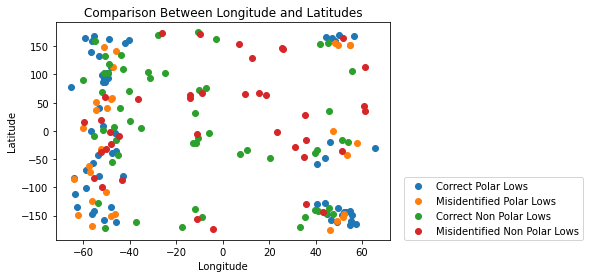

In [ ]:
# Team 2 Polar Lows Deliverable Project
# Central Latitude / Longitude Plot

## Need to convert all of the latitudes and longitudes into floats so we can add and subtract them
df_2022['latitude of box top'] = df_2022['latitude of box top'].astype(float)
df_2022['latitude of box bottom'] = df_2022['latitude of box bottom'].astype(float)
df_2022['longitude of box right side'] = df_2022['longitude of box right side'].astype(float)
df_2022['longitude of box left side'] = df_2022['longitude of box left side'].astype(float)

## Added the individual lats and lons and divided them by two to find the central lat and lon
## Store the central lats and lons in new columns in the dataframe
df_2022['central lat'] = (df_2022['latitude of box top'] + df_2022['latitude of box bottom'])/2
df_2022['central lon'] = (df_2022['longitude of box right side'] + df_2022['longitude of box left side'])/2

## Chose to do this again so that each subset would include the two new columns of central lats and lons
cor_pl_df = df_2022[df_2022['classifier'] == 'cor_pl']
incor_pl_df = df_2022[df_2022['classifier'] == 'incor_pl']
cor_npl_df = df_2022[df_2022['classifier'] == 'cor_npl']
incor_npl_df = df_2022[df_2022['classifier'] == 'incor_npl']

## Plot all of the lats and lons of all the data and label them
plt.scatter(cor_pl_df['central lat'], cor_pl_df['central lon'], label = 'Correct Polar Lows')
plt.scatter(incor_pl_df['central lat'], incor_pl_df['central lon'], label = 'Misidentified Polar Lows')
plt.scatter(cor_npl_df['central lat'], cor_npl_df['central lon'], label = 'Correct Non Polar Lows')
plt.scatter(incor_npl_df['central lat'], incor_npl_df['central lon'], label = 'Misidentified Non Polar Lows')

## Add title, axis labels, and legend
plt.title('Comparison Between Longitude and Latitudes')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.legend(loc=(1.04,0))
plt.show()

##Analysis of latitude or longitude
As you can see, the latitude values of the images vary depending on the prediction made by the model. We know that actual polar lows are going to be either below -40 or above 40 latitude. We can use this information to further classify the model's predictions into more accurate classifications.

The next plot we are going to make will be using the **confidence levels** from the dataframe. Each bar will represent either 'Correct Non-polar lows', 'Correct Polar Lows', 'Misidentified Non-Polar Lows', and 'Misidentified Polar Lows'.** Each bar is made up of the number of times each confidence level: '0', '1', or '2' was seen.  

Text(0, 0.5, 'Number of Confidence Levels')

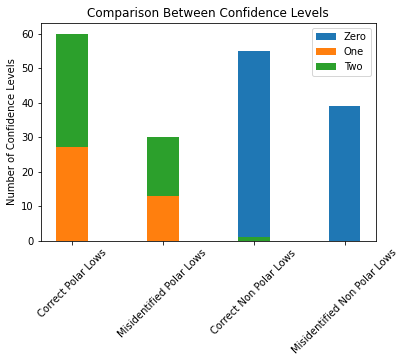

In [ ]:
# Confidence level

## Create labels based on the four categories
x2labels = ['Correct Polar Lows', 'Misidentified Polar Lows', 'Correct Non Polar Lows', 'Misidentified Non Polar Lows']

## Finds the length of how many times 0, 1, and 2 appear in each dataframe
zero = [len(cor_pl_df[cor_pl_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]'] == '0']), len(incor_pl_df[incor_pl_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]'] == '0']), len(cor_npl_df[cor_npl_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]'] == '0']), len(incor_npl_df[incor_npl_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]'] == '0'])]
one = [len(cor_pl_df[cor_pl_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]'] == '1']), len(incor_pl_df[incor_pl_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]'] == '1']), len(cor_npl_df[cor_npl_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]'] == '1']), len(incor_npl_df[incor_npl_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]'] == '1'])]
two = [len(cor_pl_df[cor_pl_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]'] == '2']), len(incor_pl_df[incor_pl_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]'] == '2']), len(cor_npl_df[cor_npl_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]'] == '2']), len(incor_npl_df[incor_npl_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]'] == '2'])]
width = 0.35

## Plot 0, 1, and 2 values
plt.bar(x2labels, zero, width, label = 'Zero')
plt.bar(x2labels, one, width, bottom = zero, label = 'One')
plt.bar(x2labels, two, width, bottom = one, label = 'Two')

## Customize plot with title, legend, etc
plt.xticks(rotation = 45)
plt.legend(loc=0)
plt.title('Comparison Between Confidence Levels')
plt.ylabel('Number of Confidence Levels')

##Analysis of confidence levels
This does not tell us much other than what we used to figure out if the data was misclassified or not. Obviously the misclassified data is going to have the opposite confidence level than what the model associated it with. Therefore, this is just an extension of showing the model's prediction results. 


For the next plot, we are going to make a stacked bar chart with 4 bars representing the same categories as before. For each bar, the stacked bar will be the **number of aqua vs terra images for each category**. 

Text(0, 0.5, 'Number of Observations')

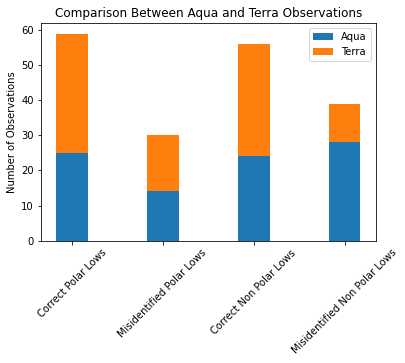

In [ ]:
# Aqua vs Terra

## Create labels based on the four categories
xlabels = ['Correct Polar Lows', 'Misidentified Polar Lows', 'Correct Non Polar Lows', 'Misidentified Non Polar Lows']

## Finds the length of how many times aqua and terra show up in each dataframe
aqua = [len(cor_pl_df[cor_pl_df['Aqua or Terra?'] == 'Aqua']), len(incor_pl_df[incor_pl_df['Aqua or Terra?'] == 'Aqua']), len(cor_npl_df[cor_npl_df['Aqua or Terra?'] == 'Aqua']), len(incor_npl_df[incor_npl_df['Aqua or Terra?'] == 'Aqua'])]
terra = [len(cor_pl_df[cor_pl_df['Aqua or Terra?'] == 'Terra']), len(incor_pl_df[incor_pl_df['Aqua or Terra?'] == 'Terra']), len(cor_npl_df[cor_npl_df['Aqua or Terra?'] == 'Terra']), len(incor_npl_df[incor_npl_df['Aqua or Terra?'] == 'Terra'])]
width = 0.35

## Plot both terra and aqua values
## Use 'bottom = aqua' to stack terra values on top of aqua values
plt.bar(xlabels, aqua, width, label = 'Aqua')
plt.bar(xlabels, terra, width, bottom = aqua, label = 'Terra')

## Customize plot with title, legend, etc
plt.xticks(rotation = 45)
plt.legend(loc=0)
plt.title('Comparison Between Aqua and Terra Observations')
plt.ylabel('Number of Observations')

##Analysis of satellites
The plot comparing the images from the Aqua versus Terra satellite also does not tell us much about what can be done to improve classification. Each classification seems to hold a close-to-even amount of images from each satellite. 

For the final plot, we will make a scatter plot using the dateframe's date category. For this plot, we will plot the month vs year data associated with each image.

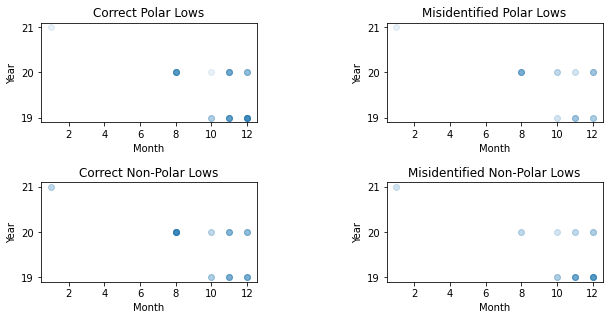

In [ ]:
# Katie

# Date category

cor_pl_df = df_2022[df_2022['classifier'] == 'cor_pl']
incor_pl_df = df_2022[df_2022['classifier'] == 'incor_pl']
cor_npl_df = df_2022[df_2022['classifier'] == 'cor_npl']
incor_npl_df = df_2022[df_2022['classifier'] == 'incor_npl']

fig = plt.figure()

# Create correct polar lows date plot
plt1 = fig.add_subplot(221)
month = []
year = []
for x in cor_pl_df['date of Polar Low Occurance']:
  x = x.split("/")
  month.append(int(x[0]))
  yearSplitter = x[-1]
  yearSplitter = yearSplitter[-2:]
  year.append(int(yearSplitter))
plt1.scatter(month, year, alpha=0.1)
month.clear()
year.clear()

# Create misidentified polar lows date plot
plt2 = fig.add_subplot(222)
month = []
year = []
for x in incor_pl_df['date of Polar Low Occurance']:
  x = x.split("/")
  month.append(int(x[0]))
  yearSplitter = x[-1]
  yearSplitter = yearSplitter[-2:]
  year.append(int(yearSplitter))
plt2.scatter(month, year, alpha=0.1)
month.clear()
year.clear()

# Create correct non-polar lows date plot
plt3 = fig.add_subplot(223)
month = []
year = []
for x in cor_npl_df['date of Polar Low Occurance']:
  x = x.split("/")
  month.append(int(x[0]))
  yearSplitter = x[-1]
  yearSplitter = yearSplitter[-2:]
  year.append(int(yearSplitter))
plt3.scatter(month, year, alpha=0.1)
month.clear()
year.clear()

# Create misidentified non-polar lows date plot
plt4 = fig.add_subplot(224)
month = []
year = []
for x in incor_npl_df['date of Polar Low Occurance']:
  x = x.split("/")
  month.append(int(x[0]))
  yearSplitter = x[-1]
  yearSplitter = yearSplitter[-2:]
  year.append(int(yearSplitter))
plt4.scatter(month, year, alpha=0.1)
month.clear()
year.clear()

## Add title, axis labels, and legend
plt1.set_title('Correct Polar Lows')
plt1.set_xlabel('Month')
plt1.set_ylabel('Year')

plt2.set_title('Misidentified Polar Lows')
plt2.set_xlabel('Month')
plt2.set_ylabel('Year')

plt3.set_title('Correct Non-Polar Lows')
plt3.set_xlabel('Month')
plt3.set_ylabel('Year')

plt4.set_title('Misidentified Non-Polar Lows')
plt4.set_xlabel('Month')
plt4.set_ylabel('Year')

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.4, 
                    top=1, 
                    wspace=0.6, 
                    hspace=0.6)

fig.show()

## Analysis of time of year data
Nothing very evident is revealed from this data analysis. We did not collect image data from across all of the possible months within a year which may be a reason for no obvious features resulting from the analysis. 

#Methods

### VGG-16 Feature Vectors

Now that we've explored the metadata associated with the correctly and incorrectly classified images, let's determine if we can identify similar images in our database that we could learn from to improve classification. VGG-16 is a neural network tool that is provided by keras. We can use this tool to extract feature vectors from our images and find similar images based on vectors. 

For this section, we will explore how we can provide a query image, extract the features of this image, and then compare these features to the other database images we have to get the most similar images.

Note we are also introducing the previous semester's data for use later in this section and throughout the rest of the notebook. We have already loaded this data for you below. We have stored this data in the variable `previous_semester_df`. 

In [ ]:
# LPRM Charles
# Load in previous semester data
with open('/content/gdrive/Shareddrives/FIRE-CC/pkl files/Spring2021PolarLowsClean.pkl','rb') as f:
   previous_semester_df = pickle.load(f)

model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
model = Model(inputs = model.input, outputs = model.get_layer('fc2').output)
model.summary()

553476096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

The following code block extracts images from two sets of data frames. The first is from the 2022 data frame and the other is from the previous semesters data frame. 

In [ ]:
# Chiamaka
# Extract 2 lists of all image paths that are in the dataframes
paths_2022 = [] ## paths in df_2022
paths_previous = [] ## paths in previous_semester_df

for row, i in enumerate(df_2022["file name of PNG"]):
  isPolarLow = df_2022['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]'] [row]!= '0'
  if isPolarLow == False: 
    path = "/content/gdrive/Shareddrives/FIRE-CC/Polar Lows/NonPolarLowSnapshots/" + i
  else:
    path = "/content/gdrive/Shareddrives/FIRE-CC/Polar Lows/Snapshots/" + i
  paths_2022.append(path)

for row, i in enumerate(previous_semester_df["file name of PNG"]):
  isPolarLow = previous_semester_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]'] [row]!= '0'
  if isPolarLow == False: 
    path = "/content/gdrive/Shareddrives/FIRE-CC/Polar Lows/NonPolarLowSnapshots/" + i
  else:
    path = "/content/gdrive/Shareddrives/FIRE-CC/Polar Lows/Snapshots/" + i
  paths_previous.append(path)

previous_semester_df.head()

,your last name,date of Polar Low Occurance,Aqua or Terra?,"How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]",latitude of box top,longitude of box right side,latitude of box bottom,longitude of box left side,file name of PNG
0,Singh,04/01/2019,Terra,1,65.8557,-18.2988,57.0696,-27.0849,190401_RS1.png
1,Olken-Hunt,7/15/2019,Aqua,2,-49.3514,-116.1654,-58.1396,-124.9536,190715_PO1.png
2,Olken-Hunt,7/15/2019,Aqua,1,-48.3226,-72.7892,-57.8317,-83.0547,190715_PO2.png
3,Olken-Hunt,07/15/2019,Aqua,0,-25.9139,-140.4504,-34.7115,-149.248,190715_PO3.png
4,Olken-Hunt,07/16/2019,Aqua,1,-41.8402,-14.1576,-50.6402,-22.9576,190716_PO1.png


This is taking the predictions and storing them into a dictionary where the key of the dictionary is the file path of the image and the values are confidence vectors for the image. This process is done twice, once for the 2022 semester and the other for the previous semester. 

In [ ]:
# Riya
# Extract features using model
# This needs to be saved as a dictionary where the key values are the current image's 
# file name and the value is the feature vector for that image.
dictionary_2022_data = {}
dictionary_prev_semester_data = {}

for i in paths_previous:
  try:
    img, x = load_image(i)
    dictionary_prev_semester_data[i] = model.predict(x)[0]
  except FileNotFoundError:
    print(i)

for i in paths_2022:
  try:
    img, x = load_image(i)
    dictionary_2022_data[i] = model.predict(x)[0]
  except FileNotFoundError:
    print(i)

/content/gdrive/Shareddrives/FIRE-CC/Polar Lows/Snapshots/190817_DP2.png 


Below is a function that will take in a dictionary where the keys are the file names of images and the values are the feature vectors associated with the images. There is an example stored in the `dic` variable that shows how this function works on data. Notice the printouts which show how the function works. The output of the function are the 10 most similar images to the query image. 

In [ ]:
# LPRM Charles
# Note that we re-declare dictionary_2022_data here to show the example. Since
# this will overwrite your current dictionary, we temporarily store it in temp 
# and then reassign it to dictionary_2022_data afterward so you don't lose your
# features.
temp = dictionary_2022_data

# define cosine distance function
def get_sim(query_img_name, dictionary):
  from scipy.spatial import distance
  # have keys as list, get index for query remove it then just use the remaining list as img
  img_files = list(dictionary.keys())
  idx = list(dictionary_2022_data.keys()).index(query_img_name)
  query_feat = dictionary_2022_data[query_img_name] # USE 2022 DATA TO GET QUERY FEATURE
  distances = []
  for img in img_files:
    d = distance.cosine(query_feat, dictionary[img])
    distances.append((img, d))

  # print(distances)
  distances.sort(key=lambda a: a[1])
  files_similar = [img for (img, _) in distances]
  return files_similar[:10]

# Declare test example
dictionary_2022_data = {'curr_semester_image.png':[20,3,1]}
dic = {'f.png':[1,0,1], 'f1.png':[1,2,1], 'f3.png':[5,20,1], 'f4.png':[2,3,4]}
# Run test example
similar_images = get_sim('curr_semester_image.png', dic)
print(similar_images)

# Reassign your features from 2022 data back to dictionary_2022_data since example is over
dictionary_2022_data = temp

['f.png', 'f1.png', 'f4.png', 'f3.png']


Now that we have the extracted features for both data sets, we can find similar images to a query image you provide. We will select 8 images from `dictionary_2022_data` to use as query images, 4 from misclassified as non polar low and 4 from misclassified as polar low. 

In [ ]:
# Ryan and Katie
# Code to select 8 query images / 4 from each category of misclassified

Query_MisClass_NPL = incorrect_classify_npl[0:4]
Query_MisClass_PL = incorrect_classify_pl[0:4]

# return 10 most similar images based on query image

###Incorrectly Classified Polar Low###
simPl = []
for l in Query_MisClass_PL:
  simPl.append(get_sim(l, dictionary_prev_semester_data))
simNpl = []
for l in Query_MisClass_NPL:
  simNpl.append(get_sim(l,dictionary_prev_semester_data))

prev_df = previous_semester_df[['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]','file name of PNG']]
SimImgL1_t = []
SimNumLPl = []

print("Misclassified Polar Lows")
for sim in simPl:
  for path in sim:
    file = path.split('/')[-1]
    t = prev_df[prev_df['file name of PNG']==file]
    x= int(t['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]'])
    SimNumLPl.append(x)
print(SimNumLPl)

SimNumLNpl = []
print("Misclassified Non Polar Lows")
for sim in simNpl:
  for path in sim:
    file = path.split('/')[-1]
    t = prev_df[prev_df['file name of PNG']==file]
    x= int(t['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]'])
    SimNumLNpl.append(x)
print(SimNumLNpl)

Misclassified Polar Lows
[0, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 0, 1, 2, 2, 1, 2, 1, 2, 0, 1, 0, 2, 2, 2, 1, 2, 0, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 1]
Misclassified Non Polar Lows
[0, 1, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 2]


The distributions of true labels are what we expected for images similar to misclassified polar lows and misclassified non-polar lows. We can observe this in the separate lists above. For the misclassified PLs, the classifications are mostly 0 which makes sense because they are actually NPLs. This means the get_sim function is working retrieving 10 similar images to its inputted image. This is the same with the misclassified NPLs as seen above since the associated classifications are mostly 2. 

### PCA Transformations

We will now explore how we can use Principal Component Analysis (PCA) to reduce the dimensionality of the feature vector from VGG16 and determine the information content of the transformed features. 

We will start by **applying PCA transformation on the feature vectors we obtained from the `df_2022` dataframe from the above step. These feature vectors should be stored in `dictionary_2022_data`**

In [ ]:
#Riya
# PCA transform 
pca = PCA()
Features = list(dictionary_2022_data.values())
pca.fit_transform(Features)
pca.explained_variance_ratio_


array([1.30139703e-01, 8.94398404e-02, 7.69433325e-02, 4.92943104e-02,
       4.53828698e-02, 3.53529003e-02, 2.92362654e-02, 2.62187408e-02,
       2.44236621e-02, 2.33424346e-02, 1.92197740e-02, 1.89838209e-02,
       1.64162615e-02, 1.60346088e-02, 1.42234272e-02, 1.38120143e-02,
       1.24752283e-02, 1.21702808e-02, 1.14481292e-02, 1.09276308e-02,
       1.06744576e-02, 9.76883593e-03, 9.68200540e-03, 8.56393789e-03,
       8.21018029e-03, 7.60524675e-03, 7.49670634e-03, 7.17958745e-03,
       6.79330587e-03, 6.68197462e-03, 6.29797115e-03, 5.97417299e-03,
       5.73879081e-03, 5.54519304e-03, 5.35564377e-03, 4.96654199e-03,
       4.90614356e-03, 4.79696255e-03, 4.69242769e-03, 4.50100154e-03,
       4.31296532e-03, 4.26824363e-03, 4.04438969e-03, 3.94771846e-03,
       3.77101373e-03, 3.69272455e-03, 3.56381066e-03, 3.52243384e-03,
       3.39169707e-03, 3.25911263e-03, 3.17062000e-03, 3.09319355e-03,
       2.99818982e-03, 2.88971910e-03, 2.83486900e-03, 2.80769007e-03,
      

Now that we have the PCA transformation, we can determine **how many principal components are needed to retain at least 95% of the variability**. Our group used the LineString method to create a line to show the intersection of the 95% variance cut off on the graph. 

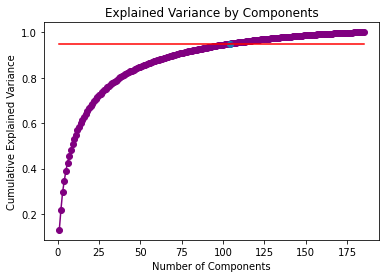

Intersection: 
array('d', [104.06746380523259]) array('d', [0.95])


In [ ]:
# Katie and Riya
xlist = []
i = 1
for j in range(pca.n_components_):
  xlist.append(i)
  i = i + 1

ylist95 = []
for j in range(pca.n_components_):
  ylist95.append(0.95)

# X is just range [1, n_components]
x = xlist
# Y is cumulative sum of explained variance ratio
y1 = np.cumsum(pca.explained_variance_ratio_)

# Create y for 95% cut-off line
y2 = ylist95

# Find the intersection for how many components are included in the 95% variance cut-off
first_line = LineString(np.column_stack((x, y1)))
second_line = LineString(np.column_stack((x, y2)))
intersection = first_line.intersection(second_line)

# Create plot
plt.plot(*intersection.xy, 'o')
plt.plot(x, y1, color='purple')
plt.scatter(x, y1, color='purple')
plt.plot(x, y2, color='red')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Components")

plt.show()

print("Intersection: ")
print(*intersection.xy)

Based upon the intersection of the explained variance ratio graph and the line representing 95% variability, we have chosen to keep 104 of the components. 

In [ ]:
# Katie and Riya
pca2 = PCA(n_components=104)
pca2
changed = pca2.fit_transform(Features)
print(changed.shape)

(185, 104)


Now we will visualize the first two principal components of all the images. 


In [ ]:
#Chiamaka
TheColumns = []

Num = 1

for comp in range(104):
  TheColumns.append("Component " + str(Num))
  Num = Num + 1

NewDf = pd.DataFrame(changed)
NewDf.columns = TheColumns
NewDf['Confidence Label'] = df_2022['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]']
NewDf['File Name Of PNG'] = df_2022['file name of PNG']
NewDf.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Component 97,Component 98,Component 99,Component 100,Component 101,Component 102,Component 103,Component 104,Confidence Label,File Name Of PNG
0,6.861254,6.855907,14.486209,5.943173,-13.882645,9.465294,11.610589,-2.815342,3.663645,5.202376,...,0.405926,1.560249,3.568902,1.640817,0.258090,-2.566384,-1.616577,2.627678,2,200811_HS1.png
1,20.163599,-0.343558,12.852166,-1.602510,-15.945211,-0.937685,16.112816,-8.063692,-9.392033,1.747413,...,-1.751707,1.454268,-0.534965,-0.500424,-0.583703,0.253024,0.628986,-0.693561,2,200811_HS2.png
2,7.531891,1.719263,-7.387958,-8.103476,-1.862984,22.799836,-2.537110,-3.232014,5.954834,17.314547,...,-2.689848,0.146409,-0.040151,-0.421151,-0.288867,-0.976970,1.190630,0.798660,2,200810_HS1.png
3,24.877487,7.244914,-8.256965,-8.334156,3.117489,-5.142053,-3.343162,1.450206,-15.231849,5.483757,...,0.932079,0.642831,0.878273,-0.669234,0.424815,-0.066194,0.376025,0.462349,2,200813_HS1.png
4,21.757107,-6.676349,0.718872,-2.606820,-11.957836,3.200716,-4.010095,1.741575,-13.007026,3.951966,...,-2.809071,-1.031581,-0.999066,0.233446,1.467959,0.359024,-0.476543,-2.713209,2,200814_HS1.png


Now we will make a scatter plot showing the first two components.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


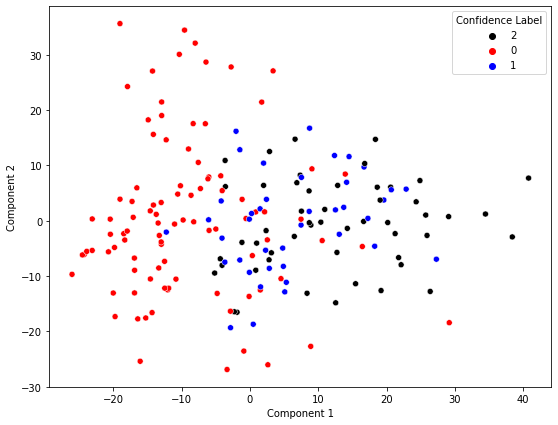

In [ ]:
#Chiamaka
#Scatter plot
x_axis = NewDf['Component 1']
y_axis = NewDf['Component 2']
plt.figure(figsize = (9, 7))
sns.scatterplot(x_axis, y_axis, hue = NewDf['Confidence Label'], palette = ['black', 'red', 'blue'])
plt.show()

The red dots that overlap the other clusters, we can consider as outliers. 

### K-Means Clustering

Here we will be using K-Means Clustering to explore if there are clusters that exist within our dataset. 

With the **principal components that are needed to get at least 95% variability, we can use these feature vectors as inputs into the k-means clustering algorithm**. For this algorithm, we will assign 2 clusters (one for polar lows and the other for non-polar lows).

In [ ]:
#Riya
kmeans = KMeans(n_clusters=2).fit(Features)

Now **visualize the found clusters on a scatter plot. For each cluster, use a different shape to represent that cluster. This could be 'x' shapes for the polar lows cluster and 'o' shapes for the non-polar lows cluster. Then use the original labels as colors for each point on the scatter plot.** This will help with noticing any patterns that the k-means clustering algorithm found.

In [ ]:
# Features
# img_correct = [curr_str.split('/')[-1] for curr_str in img]
classifier_colm = list(df_2022['classifier'])
true = [curr_str.split('_')[-1] for curr_str in classifier_colm] 

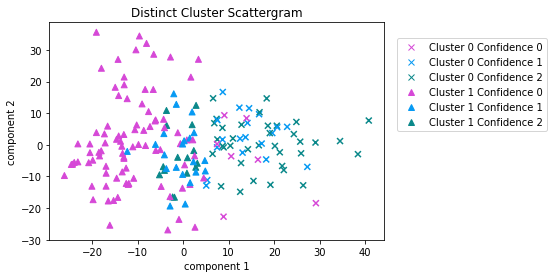

In [ ]:
#Riya, Katie, Chiamaka, Ryan
x = NewDf['Component 1']
y = NewDf['Component 2']
d = {}
# for idx,elm in enumerate(kmeans.labels_):
#   if elm == 0:
#     d[idx] = elm
clustersByIdx = kmeans.labels_
cLevels = NewDf['Confidence Label'].to_list()
# plt.scatter(x_0,y_0)
# plt.scatter(x_1,y_1)
# print(cLevels)
# print(clustersByIdx)
c = ['#d648d7','#069af3','#0a888a']
x_0 = np.array(x)[np.where(clustersByIdx == 0)]
y_0 = np.array(y)[np.where(clustersByIdx == 0)]
x_1 = np.array(x)[np.where(clustersByIdx == 1)]
y_1 = np.array(y)[np.where(clustersByIdx == 1)]
c_0 = np.array(cLevels)[np.where(clustersByIdx==0)]
c_1 = np.array(cLevels)[np.where(clustersByIdx==1)]

new_lst_c0 = [c[int(i)] for i in c_0]
new_lst_c1 = [c[int(i)] for i in c_1]
plt.scatter(x_0,y_0,marker='x', c=new_lst_c0)
plt.scatter(x_1,y_1,marker='^', c=new_lst_c1)
plt.title("Distinct Cluster Scattergram")
plt.xlabel('component 1')
plt.ylabel('component 2')

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

handles = [f("x", c[i]) for i in range(3)]
handles += [f("^", c[i]) for i in range(3)]
labels = ['Cluster 0 Confidence 0','Cluster 0 Confidence 1','Cluster 0 Confidence 2','Cluster 1 Confidence 0','Cluster 1 Confidence 1','Cluster 1 Confidence 2']
plt.legend(handles, labels, loc=(1.04,.5))

###Decision Tree


For the final part of our deliverable, we will begin the process of improving upon the models classification system by incorporating a decision tree. We created a temporary variable to store the previous semester's data frame to train our decision tree. We then converted all 2's in the data frame to 1's so that a 1 represents polar lows and a 0 represents non-polar lows. Lastly we created an array named "master" to hold the teachable machine predictions.

In [ ]:
#Riya and Chiamaka and Ryan
previous_semester_df
prediction_array = [[]]
i = 0

#temp_df is what we use later in order to train our decision tree
#used previous semesters dataframe for training decision tree 
#also used the true classification labels in temp_df
temp_df = previous_semester_df[["latitude of box top", "longitude of box right side", "How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]"]]
list_long = list(temp_df["longitude of box right side"])
list_lat = list(temp_df["latitude of box top"])
#turns all the 2's into 1's so it is either 0 or 1, this is because polar lows are classified as both 2 and 1.
#later, we can just use 0 and 1. using 0, 1, and 2, makes things redundant and matches up with the models classification labels. 
list_class = np.array(list(temp_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]']))
list_class[list_class == '2'] = '1'
#makes all of the elements in the list a type int instead of type string
truths = list(list_class.astype(int))

model = load_model('/content/gdrive/Shareddrives/FIRE-CC/FIRE298/2021/Polar Lowe\'s/RGB Model/keras_model.h5')
new_prediction_array2 = []

#creates an array of the classifications that the teachable-machine model predicts
#this will later be used to train the decision tree model. 
for idx, image in enumerate(paths_previous):
  try:
    #loads the image
    x, arr =  load_image(image)
    test = np.asarray(x)
    #raw prediction: either polar low, non-polar low, or non satellite image
    raw_prediction_array = model.predict(arr)
    #gets the highest number for the classification of polar low or npl
    prediction_array = np.argmax(raw_prediction_array,axis=1)
    #list of 0 and 1
    prediction_list = prediction_array.tolist()
    prediction = prediction_list[0]
    # Bypassing error with model, choosing second highest prediction if highest is 'Non-Satellite'
    if prediction == 2:
      new_raw_prediction_array = np.delete(raw_prediction_array, prediction, axis=1)
      new_prediction_array = np.argmax(new_raw_prediction_array, axis=1)
      new_prediction_list = new_prediction_array.tolist()
      prediction = new_prediction_list[0]
    new_prediction_array2.append(prediction)
  except:
    # if an image is missing removes it from all of the lists
    list_long.pop(idx)
    list_lat.pop(idx)
    truths.pop(idx)

#master is an array that will be passed into the decision tree containing the teachable-machine predictions, 
#latitude data, and longitude data. 
master = []
#for all the images in all the lists: long, lat, and prediction, makes in into 1 still
for i in range(len(new_prediction_array2)):
  master.append([new_prediction_array2[i], float(list_long[i]), float(list_lat[i])])
print(master)

[[1, -18.2988, 65.8557], [1, -116.1654, -49.3514], [0, -72.7892, -48.3226], [0, -140.4504, -25.9139], [1, -14.1576, -41.8402], [0, -75.6643, -54.3379], [1, 63.0109, 9.8185], [1, -118.6424, -19.2851], [1, 138.3204, 27.6751], [0, -78.614, -40.1202], [0, 163.2341, 42.1144], [0, -151.4474, -43.716], [1, 74.0809, -3.3316], [1, -162.4569, 52.8292], [1, -171.813, -36.7672], [0, -11.9452, 58.6866], [0, -25.7254, -49.6095], [0, 142.0843, 17.7291], [1, -74.5308, -21.0623], [1, 119.4088, -51.7502], [1, 154.8557, -44.2811], [1, -22.1697, 48.8619], [1, -51.2393, -50.9358], [0, -15.4465, 50.2516], [1, -48.6423, 3.7033], [1, 144.9114, 26.5227], [1, 167.8096, 54.6825], [0, -28.4317, 40.9799], [0, -111.3499, 69.1561], [0, 33.5557, -38.6208], [1, 65.3881, -43.1007], [0, -140.0659, 46.0635], [0, -1.5457, 3.6088], [0, 113.0982, -55.7195], [0, -158.3308, 18.0642], [1, -123.9565, -7.1192], [1, -23.6378, 13.8265], [0, 98.6528, -36.4169], [0, 61.6339, -49.3829], [1, 166.6794, -55.1944], [0, -123.4255, -45.484

This decision tree helps predict the classification of the images by splitting the data based on the longitude and latitude data we provided. With more depth in the tree, it leads to overfitting the data. By overfitting, the model works really well on the training data but it won't work as well on other general images. So, we changed our max_depth to be 2 in order to generalize the model more.

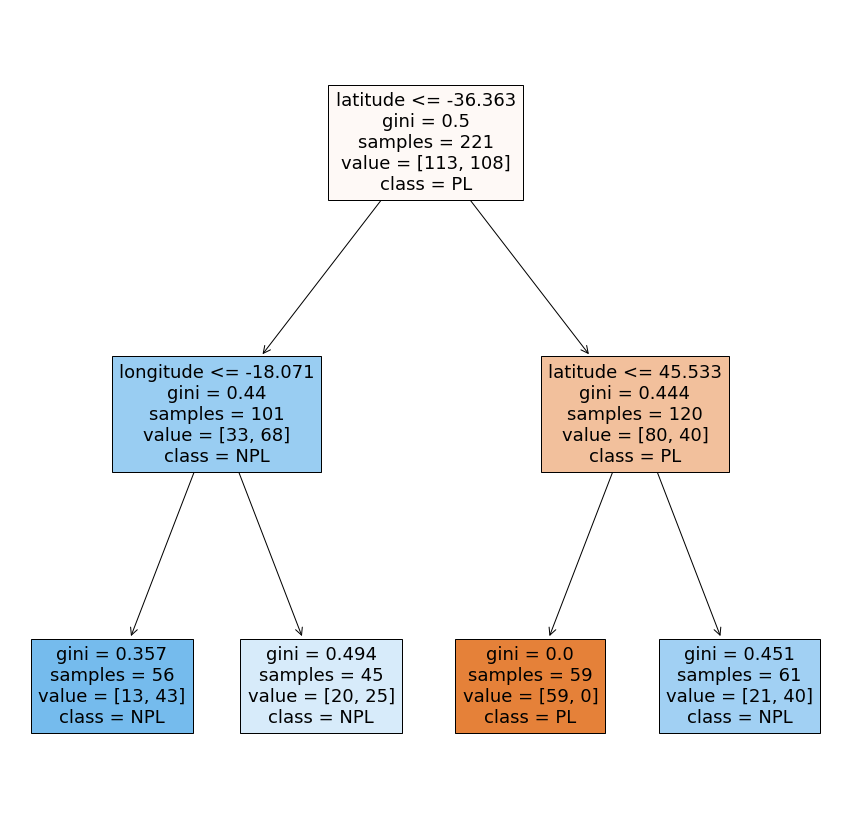

In [ ]:
#Riya and Chiamaka
#creates a tree of depth 2, if we have too many depths, it overfits(meaning it 
#trains so well that it only does well on the actual training set) 
#generalization: applying trained model to test data
# the tree is a decision maker, it goes down a path to determine the decision. 
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(master, truths)
fig = plt.figure(figsize=(15,15))
_ = tree.plot_tree(clf, feature_names=['teachable machine prediction', 'longitude', 'latitude'], class_names=['PL', 'NPL'], filled=True)

Below we created a test set using the 2022 data frame

In [ ]:
#Riya and Chiamaka
# test set process
# for a test set, we used the 2022 data as the training data
# we made a confusion matrix
temp_df = df_2022[["latitude of box top", "longitude of box right side", "How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]"]]
list_long = list(temp_df["longitude of box right side"])
list_lat = list(temp_df["latitude of box top"])
list_class = np.array(list(temp_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]']))
list_class[list_class == '2'] = '1'
test_Y = list(list_class.astype(int))

test_X = []
for i in range(len(list_long)):
  tmp_lst = [int(list_class[i]), float(list_long[i]), float(list_lat[i])]
  test_X.append(tmp_lst)

pr = clf.predict(test_X)
pr = pr.tolist()

In [ ]:
print(type(test_Y))
print(type(pr))
print(test_Y)
print(pr)

<class 'list'>
<class 'list'>
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# Conclusions

First, we will show a confusion matrix representing the initial results produced by the Teachable Machine model, before we provide any classification ourselves. 

###Results

**Here we will communicate the results of the teachable machine learning before and then after our decision tree, the classification results after, add more words here later**

The accuracy score of the model is 0.6270270270270271
The precision score for predicting polar lows is 0.6470588235294118
The precision score for predicting non-polar lows is 0.61


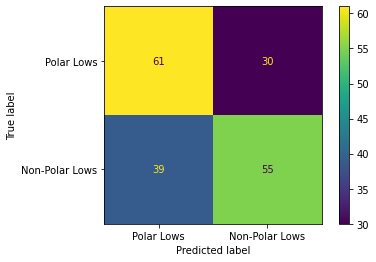

In [ ]:
#Katie
## Original Teachable Machine Model Results

# Confusion Matrix & Accuracy metrics

# Lists used from beginning of notebook containing the true and predicted labels of the images
y_true = classifications
y_pred = predictions

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=["Polar Low", "Non-Polar Low"])

#Accuracy Score
accuracy = accuracy_score(y_true, y_pred)
print("The accuracy score of the model is " + str(accuracy))

#Precision Score
precision = precision_score(y_true, y_pred, average=None)
print("The precision score for predicting polar lows is " + str(precision[0]))
print("The precision score for predicting non-polar lows is " + str(precision[1]))

#Displaying the Confusion Matrix
## Used defined labels from labels.txt in the converted_keras folder in the drive
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Polar Lows', 'Non-Polar Lows'])
disp.plot()
plt.show()


Now we will show a confusion matrix representing the results of our decision tree's predictions. 

The accuracy score of the model is 0.7351351351351352
The precision score for predicting non-polar lows is 0.9245283018867925
The precision score for predicting polar lows is 0.6590909090909091


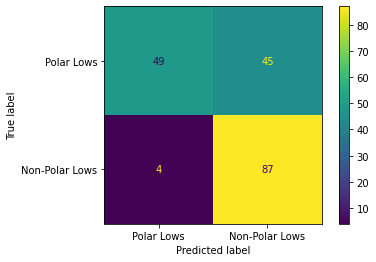

In [ ]:
# Katie
#Decision tree results. 
cm = confusion_matrix(test_Y, pr, labels=[0, 1])

#Accuracy Score
accuracy = accuracy_score(test_Y, pr)
print("The accuracy score of the model is " + str(accuracy))

#Precision Score
precision = precision_score(test_Y, pr, average=None)
print("The precision score for predicting non-polar lows is " + str(precision[0]))
print("The precision score for predicting polar lows is " + str(precision[1]))

#Displaying the Confusion Matrix
## Used defined labels from labels.txt in the converted_keras folder in the drive
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Polar Lows', 'Non-Polar Lows'])
disp.plot()
plt.show()

In [ ]:
print(test_Y)
print(test_Y_labels)
print(pr)
print(pr_labels)

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]


NameError: ignored

Overall, we were able to increase our accuracy score by around 10% through using the decision tree as compared to the teachable machine model. 

To conclude our project, we were successful in achieving our goal of 
increasing the classification of Polar Lows. To do so, we created a decision tree to classify the images by longitude and latitude. The process of using a decision tree to further classify Polar Lows proved effective with the results we had. Without using decision trees, we were able to correctly identify 62.7% (116 out of 185) of the images. With decision trees, our percent increased to 73.5% (136 out of 185) correctly identified images. Looking back at the project, something to resolve would be changing the shapes and labels of the K-Means clustering graph. Moving forward, teams can try improving the classification of the decision trees by using different parts of the dataframe. For example, a team could use confidence levels as a way to better train the model rather than longitude and latitude. This switch may provide better results than what we concluded. Additionally, we can use different values for the parameters of the decision tree classifier. 

#Bibliography

General Knowledge about Polar Lows:

Terpstra, A., & Watanabe, S.  Polar Lows. Oxford Research Encyclopedia of Climate Science. Retrieved 6 May. 2022, from https://oxfordre.com/climatescience/view/10.1093/acrefore/9780190228620.001.0001/acrefore-9780190228620-e-775.

General Knowledge about Decision Trees:

"1.10. Decision Trees.” Scikit, https://scikit-learn.org/stable/modules/tree.html

Documentation recited for decision tree process:

“Sklearn.tree.decisiontreeclassifier.” Scikit, https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict. 

Images snapshotted from NASA's worldview database:

https://worldview.earthdata.nasa.gov/?v=-285.02722596685953,-228.1341428616612,173.73453537238606,224.4000832557847&l=Graticule,Coastlines_15m,MODIS_Aqua_CorrectedReflectance_TrueColor(hidden),MODIS_Terra_CorrectedReflectance_TrueColor&lg=false&l1=Graticule,Coastlines_15m,MODIS_Aqua_CorrectedReflectance_TrueColor,MODIS_Terra_CorrectedReflectance_TrueColor&lg1=false&ca=true&t=2019-06-25-T00%3A00%3A00Z&t1=2019-06-25-T00%3A00%3A00Z


All other citations belong to Charles' brain :))))
